In [2]:
import torch
from torch import nn
import os
import glob as glob
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import random
import time
from IPython import display
import h5py
import math

In [3]:
class AE_Dataset(Dataset):
    def __init__(self, file, transform=None, target_transform=None):
        data = h5py.File(file,'r')

        p_dict = {}
        for key in data['NEO']['ParticleData'].keys():
            if key in ['Xe1_FluorPeak','Xe2_FluorPeak']:
                d0 = []
                d1 = []
                for k in range(len(data['NEO']['ParticleData'][key])):
                    if math.isnan(data['NEO']['ParticleData'][key][k][0]):
                        d0.append(0)
                    else:
                        d0.append(data['NEO']['ParticleData'][key][k][0])
                    if math.isnan(data['NEO']['ParticleData'][key][k][1]):
                        d1.append(0)
                    else:
                        d1.append(data['NEO']['ParticleData'][key][k][1])
                p_dict[key+'_0'] = d0
                p_dict[key+'_1'] = d1
            else:
                p_dict[key] = list(data['NEO']['ParticleData'][key])

        self.df = []
        mv = {}
        for key in p_dict.keys():
            mv[key] = max(p_dict[key])

        for i in range(len(p_dict['Asphericity'])):
            dp = []
            for key in p_dict.keys():
                if key in ['Density_g_cm3','EP_Overflow_Flag','Mass_ug','Seconds']:
                    pass
                else:
                    if mv[key]:
                        if math.isnan(p_dict[key][i]):
                            dp.append(0)
                        else:
                            dp.append(p_dict[key][i]/mv[key])
                            #dp.append(p_dict[key][i])
                    else:
                        dp.append(0)
            self.df.append(dp)


            
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        data = np.array(self.df[idx])
        
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)

        return data

In [38]:
dataset = AE_Dataset('/home/griffin/ML/WIBS/WIBS/20230104110216/20230104110216__x1.h5')

In [39]:
idx = np.random.randint(0, dataset.__len__())

dataset.__getitem__(idx)

array([0.10220799, 0.        , 0.0309527 , 0.0358384 , 0.01537018,
       0.01860781, 0.69473684, 0.10025063, 0.8211834 , 0.        ,
       0.        , 0.        , 0.        ])

In [40]:
trainset = Subset(dataset, range(0,int(len(dataset)*0.7)))
testset = Subset(dataset, range(int(len(dataset)*0.7), len(dataset)))

In [41]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [42]:
dataset.__len__()

119788

In [9]:
# use LeakyReLU to enable negative values, should help avoid dimension loss in AutoEncoder
class AE_Leaky(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_stack = nn.Sequential(
            nn.Linear(kwargs["input_shape"], 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16,3),
            nn.LeakyReLU(0.2))
        self.decoder_stack = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, kwargs["input_shape"]))

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        encoder_logits = self.encoder_stack(x)
        decoder_logits = self.decoder_stack(encoder_logits)
        return decoder_logits, encoder_logits

In [100]:
def loss_fn(output, target):
    loss = torch.mul(torch.mean((output-target)**2),1000)
    return loss

In [101]:
model = AE_Leaky(input_shape=13)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [102]:
epochs = 500
path = './AE_Background.pth'
for epoch in range(epochs):
    start = time.time()
    loss = 0
    for i, batch_features in enumerate(train_loader, 0):
        # reshape mini-batch data to [N, 784] matrix
        #batch_features = batch_features.view(-1, 784)

        # reset gradients
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, _ = model(batch_features.float())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features.float())
        #train_loss = loss_fn(outputs, batch_features.float())
        # compute accumulated gradients
        train_loss.backward()
        
        # clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss/len(train_loader)
    
    # display training loss
    display.clear_output(wait=True)
    print("epoch: {}/{}, loss = {:.6f}, time = {:.2f} s".format(epoch+1, epochs, loss, time.time() - start))

    torch.save(model.state_dict(), path)

epoch: 500/500, loss = 0.000184, time = 0.03 s


In [103]:
test_loader = DataLoader(testset, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
data = dataiter.next()

#path = './AE_wibs_mkI.pth'
model = AE_Leaky(input_shape=13)
model.load_state_dict(torch.load(path))
model.eval()

with torch.no_grad():
    
    outputs, coded = model(data.float())
    
    
    di = []
    oi = []
    for i in range(13):
        di.append(round(float(data[0][i]),4))
        oi.append(round(float(outputs[0][i]),4))
    print(di)
    print(oi)
    print(coded)

[0.7935, 1.0, 0.0, 0.0004, 0.0, 0.0013, 0.0248, 0.0649, 0.1035, 0.0012, 0.0033, 0.0, 0.0225]
[0.7942, 0.999, -0.0027, -0.0095, -0.0018, 0.0028, 0.0306, 0.0595, 0.1036, -0.0047, 0.0044, -0.0021, 0.0119]
tensor([[1.3977, 1.8222, 1.6504]])


In [57]:
ox = []
oy = []
oz = []
c = []

test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
dataiter = iter(test_loader)

path = './AE_wibs_mkI.pth'
model = AE_Leaky(input_shape=13)
model.load_state_dict(torch.load(path))
model.eval()

save_data = []
with torch.no_grad():
    for j in range(len(dataiter)):

        data = dataiter.next()
        outputs, coded = model(data.float())
        ox.append(float(coded[0][0]))
        oy.append(float(coded[0][1]))
        oz.append(float(coded[0][2]))

        if (-0.45*float(coded[0][0]) + 10*float(coded[0][1]) + 0.3*float(coded[0][2]) -11.9) > 0:
            c.append('green')
            label = 'Solution'
        else:
            c.append('red')
            label = 'Background'
            
        save_data.append(np.append(np.array(data[0]),label))

In [58]:
len(oz)

119788

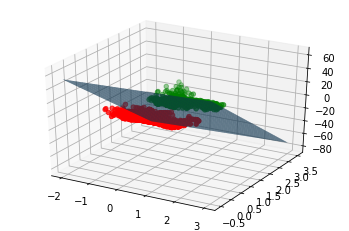

In [59]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ox, oy, oz, c=c)

x=np.linspace(-2,3,100)
y=np.linspace(-0.5,3.5,100)
x,y = np.meshgrid(x,y)
eq = (0.45/0.3)*x + (-10/0.3)*y + (11.9/0.3)

ax.plot_surface(x,y,eq,alpha=0.8)

plt.show()

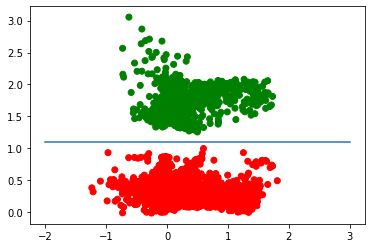

In [60]:
plt.scatter(ox, oy, c=c)
#plt.scatter(ox, oy)
plt.plot([-2,3],[1.1,1.1])

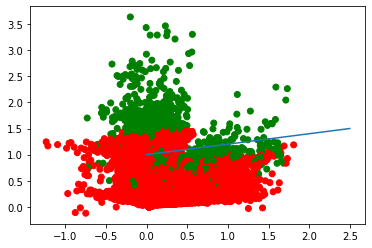

In [61]:
plt.scatter(ox, oz, c=c)
plt.plot([0,2.5],[1,1.5])

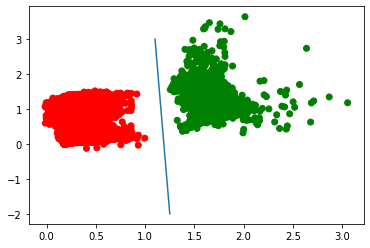

In [62]:
plt.scatter(oy, oz, c=c)
plt.plot([1.25,1.1],[-2,3])

In [50]:
# do separation and labeling magic

In [55]:
A = np.array([-2, 1.1, 0])
B = np.array([0, 1.25, -2])
C = np.array([0, 1.1, 3])

a = C - A
b = B - A

N = np.cross(a, b)
val = N[0]*-1*A[0] + N[1]*-1*A[1] + N[2]*-1*A[2]

print(f'0 = {N[0]}x + {N[1]}y + {N[2]}z + {val}')

0 = -0.44999999999999973x + 10.0y + 0.2999999999999998z + -11.899999999999999


In [92]:
save_data[1]

array(['0.366912014884586', '0.0', '0.006967707356291036',
       '0.04908774978279757', '0.004762592004618271',
       '0.019083191850594226', '0.3389139597039474',
       '0.10401002506265664', '0.5564796976916608', '0.0', '0.0', '0.0',
       '0.0', 'Background'], dtype='<U32')

In [18]:
## Create saving data function

In [63]:
save_file_name = 'label_data_no_CC.txt'

num_lines = 0
with open(save_file_name, 'a') as f:
    for sd in save_data:
        num_lines += 1
        for i in range(len(sd)-1):
            f.write(str(sd[i])+',')
        f.write(str(sd[-1])+'\n')

print(f'{num_lines} data lines written')

119788 data lines written


In [ ]:
## Classifier Neural Net

# Need to gather specific data:
# air
# only 1 soln
# soln mixture

# run through AE and see how they look
# put in classifier, etc